In [11]:
import os
print(os.getcwd())

/home/udit/programs/Synaptic-Flow/Notebooks


In [12]:
import sys
sys.path.append("/home/udit/programs/Synaptic-Flow/")

In [13]:
args = {
"dataset" : "mnist", # ['mnist','cifar10','cifar100','tiny-imagenet','imagenet']
"model" : "fc", # ['fc','fc-orth','conv','conv-orth','strconv', ... <take rest from main.py>]
"model_class" : "default", # ['default','lottery','tinyimagenet','imagenet']
"dense_classifier" : False,
"pretrained" : False,
"optimizer" : "adam", # ['sgd','momentum','adam','rms']
"train_batch_size" : 64,
"test_batch_size" : 256,
"pre_epochs" : 0, # number of epochs to train before pruning
"post_epochs" : 10, # number of epochs to train after pruning
"lr" : 1e-3,
"lr_drops" : [],
"lr_drop_rate" : 0.1,
"weight_decay" : 0.0 ,
"save" : False,
"scale" : 1,

# pruning args
"pruner" : "synflow", # ['rand','mag','snip','grasp','synflow']
"compression" : 1.0, # quotient of prunable non-zero prunable parameters before and after pruning (defaul"t: 1.0)
"prune_epochs" : 1, # number of iterations for scoring (defaul"t: 1)
"compression_schedule" : "exponential", # ['linear','exponential']
"mask_scope" : "global", # ['global','local']
"prune_dataset_ratio" : 10, # ratio of prune dataset size and number of classes (defaul"t: 10)'
"prune_batch_size" : 256, # input batch size for pruning (defaul"t: 256)
"prune_bias" : False,
"prune_batchnorm" : False,
"prune_residual" : False,
"reinitialize" : False, # whether to reinitialize weight parameters after pruning (defaul"t: False)
"pruner_list" : [], # list of pruning strategies for singleshot (defaul"t: [])
"prune_epoch_list" : [], # list of prune epochs for singleshot (defaul"t: [])
"compression_list" : [], # list of compression ratio exponents for singleshot/multishot (defaul"t: [])
"level_list" : [],
"experiment" : "prune-only", # ['example',"prune-only",'singleshot','multishot','unit-conservation', 'layer-conservation','imp-conservation','schedule-conservation']
"expid" : "",
"result_dir" : "Results/data",
"gpu" : "0",
"workers" : 4,
"no_cuda" : False,
"seed" : 1,
"verbose" : False,
"save_pruned" : False,
"save_pruned_path" : "Results/pruned"
}

In [133]:
import torch
from torch import norm
import pandas as pd
import numpy as np
from tqdm import tqdm

w_across_epochs = []

def train(model, loss, optimizer, dataloader, device, epoch, verbose, classifier_model, log_interval=10):
    model.train()
    total = 0
    train_loss = 0
    batch_train_limit = 2
    print("Training for {} batches only out of {}".format(batch_train_limit, len(dataloader)))
    for batch_idx, (data, target) in enumerate(dataloader):
        if (batch_idx >= batch_train_limit):
            break
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        if classifier_model:
            train_loss = loss(output, target)
        else:
            train_loss = loss(output, target.float())
        total += train_loss.item() * data.size(0)
        train_loss.backward()
        optimizer.step()
        if verbose & (batch_idx % log_interval == 0):
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(dataloader.dataset),
                100. * batch_idx / len(dataloader), train_loss.item()))
    return total / len(dataloader.dataset)

def eval(model, loss, dataloader, device, verbose, classifier_model):
    model.eval()
    total = 0
    correct1 = 0
    if classifier_model:
        with torch.no_grad():
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                output = model(data)
                total += loss(output, target).item() * data.size(0)
                _, pred = output.topk(1, dim=1)
                correct = pred.eq(target.view(-1, 1).expand_as(pred))
                correct1 += correct[:,:1].sum().item()
        average_loss = total / len(dataloader.dataset)
        accuracy1 = 100. * correct1 / len(dataloader.dataset)
    else: 
        with torch.no_grad():
            for data, target in dataloader:
                data, target = data.to(device), target.to(device)
                output = model(data)

                total += loss(output, target.view(-1,1)).item() * data.size(0)
                correct = output.eq(target.view(-1, 1).expand_as(output))
                correct1 += correct[:,:1].sum().item()
        average_loss = total / len(dataloader.dataset)
        accuracy1 = 100. * correct1 / len(dataloader.dataset)


    if verbose:
        print('Evaluation: Average loss: {:.4f}, Top 1 Accuracy: {}/{} ({:.2f}%)'.format(
            average_loss, correct1, len(dataloader.dataset), accuracy1))
    return average_loss, accuracy1

def train_eval_loop(model, loss, optimizer, scheduler, train_loader, test_loader, device,
                    epochs, verbose, classifier_model):
    test_loss, accuracy1 = eval(model, loss, test_loader, device, verbose, classifier_model=classifier_model)
    budge = 0
    rows = [[np.nan, test_loss, accuracy1, budge]]
    allw0 = -1
    allw = -1
    for epoch in tqdm(range(epochs)):
        train_loss = train(model, loss, optimizer, train_loader, device, 
                           epoch, verbose, classifier_model=classifier_model)
        if epoch == 0:
            allw0 = nn.utils.parameters_to_vector(model.parameters()).detach().cpu().numpy().copy()
            w_across_epochs.append(allw0)
        else:
            allw = nn.utils.parameters_to_vector(model.parameters()).detach().cpu().numpy().copy()
            w_across_epochs.append(allw)
            budge = np.linalg.norm(allw-allw0)/np.linalg.norm(allw0)
        test_loss, accuracy1 = eval(model, loss, test_loader, device, 
                                    verbose, classifier_model=classifier_model)
        row = [train_loss, test_loss, accuracy1, budge]
        print("Epoch: {} - metrics {}".format(epoch, row))
        scheduler.step()
        rows.append(row)
    columns = ['train_loss', 'test_loss', 'top1_accuracy', 'budge']
    return pd.DataFrame(rows, columns=columns)

In [15]:
import torch
import torch.nn as nn
import numpy as np
from Layers import layers
import Layers
from torch.nn import functional as F
import copy
class ZeroOutput(nn.Module):
    """Zero the output of a model by subtracting out a copy of it."""

    def __init__(self, model):
        super().__init__()
        self.init_model = [copy.deepcopy(model).eval()]

        self.model = model

    def forward(self, inp):
        return self.model(inp) - self.init_model[0](inp)


class Scale(nn.Module):
    """Scale the output of the model by alpha."""

    def __init__(self, model, alpha):
        super().__init__()
        self.model = model
        self.alpha = alpha

    def forward(self, inp):
        return self.alpha*self.model(inp)

def fc_cla(input_shape, num_classes, dense_classifier=False, pretrained=False, L=3, N=20, 
           nonlinearity=nn.ReLU(), scale=1):
    size = np.prod(input_shape)
  
    # Linear feature extractor
    modules = [nn.Flatten()]
    modules.append(layers.Linear(size, N))
    modules.append(nonlinearity)
    for i in range(L-2):
        modules.append(layers.Linear(N,N))
        modules.append(nonlinearity)

    # Linear classifier
    if dense_classifier:
        modules.append(nn.Linear(N, num_classes))
    else:
        modules.append(layers.Linear(N, num_classes))
    # modules.append(nn.Linear(num_classes, 1))
    model = nn.Sequential(*modules)
    model = Scale(model, scale)
    
    print("Classification: Depth {}, Width {}, Scale {}".format(L, N, scale))
    # Pretrained model
    if pretrained:
        print("WARNING: this model does not have pretrained weights.")

    return model

def fc_reg(input_shape, num_classes, dense_classifier=False, pretrained=False, L=3, N=20, 
           nonlinearity=nn.ReLU(), scale=1):
    size = np.prod(input_shape)
    print("Regression: Depth {}, Width {}, Scale {}".format(L, N, scale))
  
    # Linear feature extractor
    modules = [nn.Flatten()]
    modules.append(layers.Linear(size, N))
    modules.append(nonlinearity)
    for i in range(L-2):
        modules.append(layers.Linear(N,N))
        modules.append(nonlinearity)

    # Linear classifier
    if dense_classifier:
        modules.append(nn.Linear(N, 1))
    else:
        modules.append(layers.Linear(N, 1))
    # modules.append(nn.Linear(num_classes, 1))
    model = nn.Sequential(*modules)
    model = Scale(model, scale)

    print("Regression: Depth {}, Width {}, Scale {}".format(L, N, scale))
    # Pretrained model
    if pretrained:
        print("WARNING: this model does not have pretrained weights.")

    return model

In [16]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from Utils import load
from Utils import generator
from Utils import metrics
from prune import *
import matplotlib.pyplot as plt

import os

def prune_only(args):
    print("Pruning only")
    
    ## Random Seed and Device ##
    torch.manual_seed(args["seed"])
    device = load.device(args["gpu"])
    
    ## Data ##
    print('Loading {} dataset.'.format(args["dataset"]))
    input_shape, num_classes = load.dimension(args["dataset"]) 
    prune_loader = load.dataloader(args["dataset"], args["prune_batch_size"], True, args["workers"], 
                                   args["prune_dataset_ratio"] * num_classes)
    train_loader = load.dataloader(args["dataset"], args["train_batch_size"], True, args["workers"])
    test_loader = load.dataloader(args["dataset"], args["test_batch_size"], False, args["workers"])
    
    
    ## Model, Loss, Optimizer ##
    print('Creating {}-{} model.'.format(args["model_class"], args["model"]))
    model = fc_cla(input_shape, num_classes, args["dense_classifier"], 
                   args["pretrained"], scale=args["scale"], L=args["depth"], N=args["width"]).to(device)
    classifier_model = True
    if args["model-type"] == "fc_reg":
        model = fc_reg(input_shape, num_classes, args["dense_classifier"], 
                       args["pretrained"], scale=args["scale"], L=args["depth"], N=args["width"]).to(device)
        classifier_model = False
    
    loss = nn.CrossEntropyLoss()
    if not classifier_model:
        print("Using MSE Loss")
        loss = nn.MSELoss()
        
    opt_class, opt_kwargs = load.optimizer(args["optimizer"])
    optimizer = opt_class(generator.parameters(model), lr=args["lr"], 
                          weight_decay=args["weight_decay"], **opt_kwargs)
    scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=args["lr_drops"], 
                                                     gamma=args["lr_drop_rate"])
    
    ## Pre-Train ##
    #print('Pre-Train for {} epochs.'.format(args.pre_epochs))
    pre_result = train_eval_loop(model, loss, optimizer, scheduler, train_loader, 
                                 test_loader, device, 0, args["verbose"], classifier_model = classifier_model)
    
    
    ## Prune ##
    print('Pruning with {} for {} epochs.'.format(args["pruner"], args["prune_epochs"]))
    pruner = load.pruner(args["pruner"])(generator.masked_parameters(model, args["prune_bias"], 
                       args["prune_batchnorm"], args["prune_residual"]))
    sparsity = 10**(-float(args["compression"]))
    print("Sparsity: {}".format(sparsity))
    save_pruned_path = args["save_pruned_path"] + "/%s/%s/%s" % (args["model_class"], 
                                                                 args["model"], args["pruner"],)
    if (args["save_pruned"]):
        print("Saving pruned models to: %s" % (save_pruned_path, ))
        if not os.path.exists(save_pruned_path):
            os.makedirs(save_pruned_path)
    prune_loop(model, loss, pruner, prune_loader, device, sparsity, 
               args["compression_schedule"], args["mask_scope"], args["prune_epochs"], 
               args["reinitialize"], args["save_pruned"], save_pruned_path)
    
    prune_result = metrics.summary(model, pruner.scores,
                                   metrics.flop(model, input_shape, device),
                                   lambda p: generator.prunable(p, args["prune_batchnorm"], 
                                    args["prune_residual"]))
    total_params = int((prune_result['sparsity'] * prune_result['size']).sum())
    possible_params = prune_result['size'].sum()
    total_flops = int((prune_result['sparsity'] * prune_result['flops']).sum())
    possible_flops = prune_result['flops'].sum()
    print("Parameter Sparsity: {}/{} ({:.4f})".format(total_params, 
                                                      possible_params, total_params / possible_params))
    print("FLOP Sparsity: {}/{} ({:.4f})".format(total_flops, 
                                                 possible_flops, total_flops / possible_flops))
    
    ## Post-Train ##
    #print('Post-Training for {} epochs.'.format(args.post_epochs))
    post_result = train_eval_loop(model, loss, optimizer, scheduler, train_loader, 
                                  test_loader, device, args["post_epochs"], args["verbose"], 
                                  classifier_model = classifier_model)
    
    
    ## Display Results ##
#     frames = [pre_result.head(1), post_result.head(1), post_result.tail(1)]
#     train_result = pd.concat(frames, keys=['Init.', 'Post-Prune', "Final"])

#     print("Train results:\n", train_result)
#     print("Prune results:\n", prune_result)

    ## Save Results and Model ##
    if args["save"]:
        print('Saving results.')
        pre_result.to_pickle("{}/pre-train.pkl".format(args["result_dir"]))
        post_result.to_pickle("{}/post-train.pkl".format(args["result_dir"]))
        prune_result.to_pickle("{}/compression.pkl".format(args["result_dir"]))
        torch.save(model.state_dict(),"{}/model.pt".format(args["result_dir"]))
        torch.save(optimizer.state_dict(),"{}/optimizer.pt".format(args["result_dir"]))
        torch.save(pruner.state_dict(),"{}/pruner.pt".format(args["result_dir"]))
    
    # to change
    return post_result

In [17]:
def plot_and_save(col, width_metrics, width_list, pruner, title):
    plt.clf()
    fig, ax = plt.subplots()
    
    for m in width_list:
        res = width_metrics[m]
        res.plot(y=col, ax=ax, label="{} {}".format(pruner, m))
    fig.suptitle(col, fontsize=20)
    plt.xlabel('epoch', fontsize=18)
    plt.ylabel(col, fontsize=16)
    plt.savefig(title + " " + col)

In [18]:
def prune_train_loop(model_type, pruner, compression, prune_epochs, train_epochs, depth, width):
    args["optimizer"] = "sgd"
    args["compression"] = compression
    args["pruner"] = pruner
    args["model-type"] = model_type # "fc_cla" , "fc_reg"
    args["prune_epochs"] = prune_epochs
    args["post_epochs"] = train_epochs
    args["depth"] = depth
    args["width"] = width
    
    post_result = prune_only(args)
    
    return post_result

In [19]:
def pruner_multiple_widths_plot_loop(model_type, pruner, compression, prune_epochs, 
                                     train_epochs, depth, width_list, col_list, title=""):
    metrics = {}
    for width in width_list:
        res = prune_train_loop(model_type, pruner, compression, prune_epochs, train_epochs, depth, width)
        metrics[width] = res
    
    for metric_col in col_list:
        plot_and_save(metric_col, metrics, width_list, pruner, title)

In [94]:
prune_train_loop(model_type = "fc_cla", pruner = "synflow", compression = 1.0, prune_epochs = 3, 
                 train_epochs = 10, depth = 4, width = 10)

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1


0it [00:00, ?it/s]
  0%|          | 0/3 [00:00<?, ?it/s]

Pruning with synflow for 3 epochs.
Sparsity: 0.1


100%|██████████| 3/3 [00:00<00:00,  6.97it/s]

Parameter Sparsity: 853/8180 (0.1043)
FLOP Sparsity: 853/8180 (0.1043)



 10%|█         | 1/10 [00:02<00:25,  2.83s/it]

Epoch: 0 - metrics [2.304949356842041, 2.2857626770019532, 10.73, 0]


 20%|██        | 2/10 [00:05<00:22,  2.82s/it]

Epoch: 1 - metrics [2.245956461461385, 2.1878673946380616, 26.64, 0.13841367]


 30%|███       | 3/10 [00:08<00:19,  2.82s/it]

Epoch: 2 - metrics [2.0600093920389813, 1.9297950466156006, 28.96, 0.35460314]


 40%|████      | 4/10 [00:11<00:16,  2.81s/it]

Epoch: 3 - metrics [1.7958862186431885, 1.6636578161239624, 45.48, 0.54845]


 50%|█████     | 5/10 [00:14<00:14,  2.81s/it]

Epoch: 4 - metrics [1.4860593592325846, 1.3177692344665528, 55.54, 0.76030755]


 60%|██████    | 6/10 [00:16<00:11,  2.80s/it]

Epoch: 5 - metrics [1.2199909648895264, 1.1427341884613038, 60.09, 0.8983383]


 70%|███████   | 7/10 [00:19<00:08,  2.79s/it]

Epoch: 6 - metrics [1.0916282157580057, 1.0362024146080018, 65.27, 0.98707366]


 80%|████████  | 8/10 [00:22<00:05,  2.78s/it]

Epoch: 7 - metrics [0.9967074700673422, 0.9584716404914856, 68.2, 1.0573688]


 90%|█████████ | 9/10 [00:25<00:02,  2.81s/it]

Epoch: 8 - metrics [0.9344416560808817, 0.9145355313301087, 69.26, 1.1093581]


100%|██████████| 10/10 [00:27<00:00,  2.80s/it]

Epoch: 9 - metrics [0.897985308710734, 0.8865129982948303, 70.22, 1.1494025]


,train_loss,test_loss,top1_accuracy,budge
0,NaN,2.321718,9.58,0.000000
1,2.304949,2.285763,10.73,0.000000
2,2.245956,2.187867,26.64,0.138414
3,2.060009,1.929795,28.96,0.354603
4,1.795886,1.663658,45.48,0.548450
5,1.486059,1.317769,55.54,0.760308
6,1.219991,1.142734,60.09,0.898338
7,1.091628,1.036202,65.27,0.987074
8,0.996707,0.958472,68.20,1.057369
9,0.934442,0.914536,69.26,1.109358


In [93]:
w_across_epochs = []

In [95]:
prev_zero_index_list = None
for i in range(len(w_across_epochs)):
    zero_index_list = np.array(np.where(w_across_epochs[0] == 0)[0])
    if (prev_zero_index_list is None):
        prev_zero_index_list = zero_index_list
    
    if (prev_zero_index_list==zero_index_list).all() != True:
        print(i)
        print(len(zero_index_list))

In [96]:
array_w_across_epochs = np.array(w_across_epochs)

In [97]:
array_w_across_epochs

array([[ 0.02857571,  0.03108684,  0.        , ...,  0.03040915,
         0.09961426, -0.25341436],
       [ 0.02857571,  0.02548729,  0.        , ...,  0.05428047,
         0.08067912, -0.20144086],
       [ 0.02857571,  0.01477984,  0.        , ...,  0.03819221,
         0.10089904, -0.15375695],
       ...,
       [ 0.02857571, -0.01773159,  0.        , ..., -0.01347829,
         0.11197428, -0.11771973],
       [ 0.02857571, -0.01953074,  0.        , ..., -0.0107859 ,
         0.12871137, -0.11507058],
       [ 0.02857571, -0.02225536,  0.        , ..., -0.0069651 ,
         0.14740641, -0.11449391]], dtype=float32)

In [98]:
norm_array = array_w_across_epochs - array_w_across_epochs[0]

In [118]:
print(array_w_across_epochs)

[[ 0.02857571  0.03108684  0.         ...  0.03040915  0.09961426
  -0.25341436]
 [ 0.02857571  0.02548729  0.         ...  0.05428047  0.08067912
  -0.20144086]
 [ 0.02857571  0.01477984  0.         ...  0.03819221  0.10089904
  -0.15375695]
 ...
 [ 0.02857571 -0.01773159  0.         ... -0.01347829  0.11197428
  -0.11771973]
 [ 0.02857571 -0.01953074  0.         ... -0.0107859   0.12871137
  -0.11507058]
 [ 0.02857571 -0.02225536  0.         ... -0.0069651   0.14740641
  -0.11449391]]


In [119]:
print(array_w_across_epochs[0])

[ 0.02857571  0.03108684  0.         ...  0.03040915  0.09961426
 -0.25341436]


In [120]:
print(norm_array)

[[ 0.          0.          0.         ...  0.          0.
   0.        ]
 [ 0.         -0.00559956  0.         ...  0.02387132 -0.01893514
   0.05197351]
 [ 0.         -0.01630701  0.         ...  0.00778306  0.00128478
   0.09965742]
 ...
 [ 0.         -0.04881843  0.         ... -0.04388744  0.01236002
   0.13569462]
 [ 0.         -0.05061758  0.         ... -0.04119505  0.02909711
   0.13834378]
 [ 0.         -0.05334221  0.         ... -0.03737425  0.04779215
   0.13892046]]


0.68396306 -0.4532597


In [99]:
print(zero_index_list)

[   2    5    6 ... 7884 8030 8117]


In [100]:
div = np.divide(norm_array, array_w_across_epochs[0])

/home/udit/anaconda3/envs/synflow-py3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.


In [123]:
print(div.max(), div.min())

57.25447 -98.95554


In [101]:
div = np.nan_to_num(div)

In [103]:
div[:, 7840] = 0

 ...]

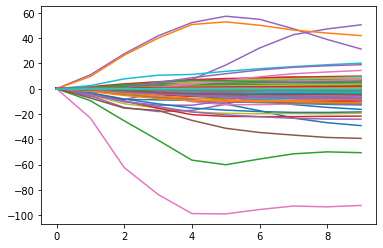

In [104]:
plt.clf()
x = [i for i in range(10)]

plt.plot(x, div[:,0:])

In [84]:
print(div[9,:].argsort())

[7840 1026 1412 ...  234 2731  154]


In [85]:
div[9, :]

array([ 0.        , -1.7159095 ,  0.        , ..., -1.2290461 ,
        0.47977218, -0.5481949 ], dtype=float32)

In [86]:
div[:, 7840]

array([   -0.    ,  -417.2006, -1214.9655, -2005.2783, -2742.6267,
       -3261.614 , -3471.9773, -3637.2595, -3771.3171, -3974.3376],
      dtype=float32)

In [106]:
w_across_epochs = []
prune_train_loop(model_type = "fc_cla", pruner = "synflow", compression = 1.0, prune_epochs = 0, 
                 train_epochs = 10, depth = 4, width = 10)
pruned_prev_zero_index_list = None
for i in range(len(w_across_epochs)):
    pruned_zero_index_list = np.array(np.where(w_across_epochs[0] == 0)[0])
    if (pruned_prev_zero_index_list is None):
        pruned_prev_zero_index_list = pruned_zero_index_list
    
    if (pruned_prev_zero_index_list==pruned_zero_index_list).all() != True:
        print(i)
        print(len(pruned_zero_index_list))
pruned_array_w_across_epochs = np.array(w_across_epochs)
pruned_norm_array = pruned_array_w_across_epochs - pruned_array_w_across_epochs[0]
pruned_div = np.divide(pruned_norm_array, pruned_array_w_across_epochs[0])
pruned_div = np.nan_to_num(pruned_div)

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 8140.0 prunable parameters remaining, expected 814.0
Parameter Sparsity: 8180/8180 (1.0000)
FLOP Sparsity: 8180/8180 (1.0000)



 10%|█         | 1/10 [00:02<00:25,  2.82s/it]

Epoch: 0 - metrics [2.1585089893341065, 1.8456954341888427, 42.36, 0]


 20%|██        | 2/10 [00:05<00:22,  2.81s/it]

Epoch: 1 - metrics [1.4339815561930338, 1.04956379404068, 67.03, 0.33472058]


 30%|███       | 3/10 [00:08<00:19,  2.81s/it]

Epoch: 2 - metrics [0.8861891474723816, 0.7347940007209778, 77.57, 0.5103023]


 40%|████      | 4/10 [00:11<00:16,  2.83s/it]

Epoch: 3 - metrics [0.6824489474932353, 0.5953148818016052, 81.86, 0.60772246]


 50%|█████     | 5/10 [00:14<00:14,  2.83s/it]

Epoch: 4 - metrics [0.5660224428653717, 0.5109249069690704, 84.67, 0.67552996]


 60%|██████    | 6/10 [00:16<00:11,  2.82s/it]

Epoch: 5 - metrics [0.49359833286603294, 0.4551978671550751, 86.44, 0.72842675]


 70%|███████   | 7/10 [00:19<00:08,  2.81s/it]

Epoch: 6 - metrics [0.44763276245594025, 0.4182689126014709, 87.43, 0.77102226]


 80%|████████  | 8/10 [00:22<00:05,  2.80s/it]

Epoch: 7 - metrics [0.4172444159348806, 0.40164906432628633, 88.03, 0.80560786]


 90%|█████████ | 9/10 [00:25<00:02,  2.79s/it]

Epoch: 8 - metrics [0.39479653935432435, 0.3743536623954773, 88.9, 0.8347225]


100%|██████████| 10/10 [00:28<00:00,  2.80s/it]

Epoch: 9 - metrics [0.3775202609062195, 0.35877442486286165, 89.42, 0.8603287]


 ...]

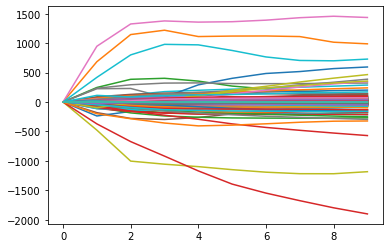

In [107]:
plt.clf()
x = [i for i in range(10)]

plt.plot(x, pruned_div[:,0:])

In [108]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [110]:
len(zero_index_list)

6386

In [111]:
synflow_div_nz = np.delete(div, zero_index_list, axis=1)

In [112]:
vanilla_div_nz = np.delete(pruned_div, zero_index_list, axis=1)

 ...]

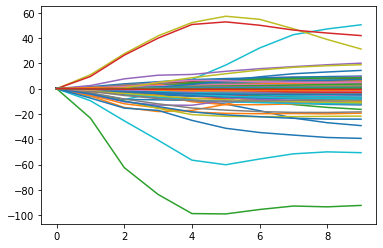

In [113]:
plt.clf()
plt.plot(x, synflow_div_nz)

 ...]

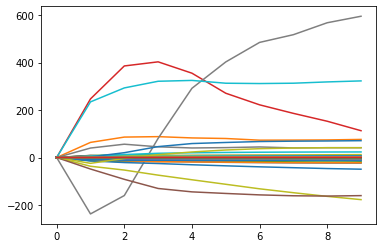

In [114]:
plt.clf()
plt.plot(x, vanilla_div_nz)

In [115]:
vanilla_pruned_weights_div_z = pruned_div[:, zero_index_list]

 ...]

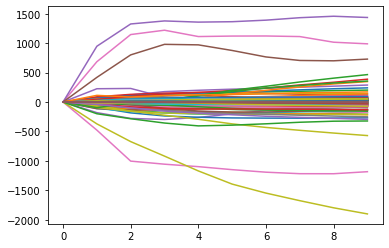

In [116]:
plt.clf()
plt.plot(x, vanilla_pruned_weights_div_z)

In [117]:
print(synflow_div_nz.shape)
print(vanilla_div_nz.shape)
print(vanilla_pruned_weights_div_z.shape)

(10, 1794)
(10, 1794)
(10, 6386)


# NTK

In [135]:
post_result = prune_train_loop(model_type = "fc_reg", pruner = "synflow", compression = 1.0, prune_epochs = 0, 
                 train_epochs = 50, depth = 4, width = 10)

Pruning only
Loading mnist dataset.
Creating default-fc model.
Classification: Depth 4, Width 10, Scale 1
Regression: Depth 4, Width 10, Scale 1
Regression: Depth 4, Width 10, Scale 1
Using MSE Loss


0it [00:00, ?it/s]
0it [00:00, ?it/s]

Pruning with synflow for 0 epochs.
Sparsity: 0.1
ERROR: 8050.0 prunable parameters remaining, expected 805.0
Parameter Sparsity: 8081/8081 (1.0000)
FLOP Sparsity: 8081/8081 (1.0000)



  0%|          | 0/50 [00:00<?, ?it/s]

Training for 2 batches only out of 938


  2%|▏         | 1/50 [00:00<00:35,  1.40it/s]

Epoch: 0 - metrics [0.04977153116861979, 24.662281741333008, 0.0, 0]
Training for 2 batches only out of 938


  4%|▍         | 2/50 [00:01<00:33,  1.43it/s]

Epoch: 1 - metrics [0.054252587890625, 23.907858169555663, 0.0, 0.02059385]
Training for 2 batches only out of 938


  6%|▌         | 3/50 [00:02<00:32,  1.45it/s]

Epoch: 2 - metrics [0.06183707682291667, 23.098415646362305, 0.0, 0.042006984]
Training for 2 batches only out of 938


  8%|▊         | 4/50 [00:02<00:32,  1.43it/s]

Epoch: 3 - metrics [0.048090401204427084, 22.296840661621093, 0.0, 0.062018897]
Training for 2 batches only out of 938


 10%|█         | 5/50 [00:03<00:31,  1.43it/s]

Epoch: 4 - metrics [0.0498494140625, 21.36534905090332, 0.0, 0.08278127]
Training for 2 batches only out of 938


 12%|█▏        | 6/50 [00:04<00:29,  1.48it/s]

Epoch: 5 - metrics [0.04818019612630208, 20.064742483520508, 0.0, 0.10769225]
Training for 2 batches only out of 938


 14%|█▍        | 7/50 [00:04<00:29,  1.47it/s]

Epoch: 6 - metrics [0.04107216593424479, 18.387782772827148, 0.0, 0.1343135]
Training for 2 batches only out of 938


 16%|█▌        | 8/50 [00:05<00:28,  1.48it/s]

Epoch: 7 - metrics [0.03338072306315104, 16.33908744506836, 0.0, 0.16162513]
Training for 2 batches only out of 938


 18%|█▊        | 9/50 [00:06<00:27,  1.48it/s]

Epoch: 8 - metrics [0.037173177083333335, 12.912886795043946, 0.0, 0.2008087]
Training for 2 batches only out of 938


 20%|██        | 10/50 [00:06<00:26,  1.50it/s]

Epoch: 9 - metrics [0.026399313354492186, 10.035250283050537, 0.0, 0.23418291]
Training for 2 batches only out of 938


 22%|██▏       | 11/50 [00:07<00:26,  1.47it/s]

Epoch: 10 - metrics [0.02259889119466146, 8.277403769683838, 0.0, 0.26455626]
Training for 2 batches only out of 938


 24%|██▍       | 12/50 [00:08<00:25,  1.49it/s]

Epoch: 11 - metrics [0.019471138509114583, 8.086915054321288, 0.0, 0.2772666]
Training for 2 batches only out of 938


 26%|██▌       | 13/50 [00:08<00:24,  1.50it/s]

Epoch: 12 - metrics [0.020143147786458333, 8.049067008972168, 0.0, 0.2779471]
Training for 2 batches only out of 938


 28%|██▊       | 14/50 [00:09<00:24,  1.49it/s]

Epoch: 13 - metrics [0.01930115763346354, 8.049520135498048, 0.0, 0.2759797]
Training for 2 batches only out of 938


 30%|███       | 15/50 [00:10<00:23,  1.51it/s]

Epoch: 14 - metrics [0.020965408325195313, 8.03947160949707, 0.0, 0.27726632]
Training for 2 batches only out of 938


 32%|███▏      | 16/50 [00:10<00:22,  1.51it/s]

Epoch: 15 - metrics [0.018653628540039064, 8.213327835083009, 0.0, 0.26754704]
Training for 2 batches only out of 938


 34%|███▍      | 17/50 [00:11<00:22,  1.49it/s]

Epoch: 16 - metrics [0.0193213623046875, 8.137376483154297, 0.0, 0.27074432]
Training for 2 batches only out of 938


 36%|███▌      | 18/50 [00:12<00:21,  1.49it/s]

Epoch: 17 - metrics [0.020050377400716145, 8.01754481201172, 0.0, 0.28434828]
Training for 2 batches only out of 938


 38%|███▊      | 19/50 [00:12<00:21,  1.45it/s]

Epoch: 18 - metrics [0.020668550618489583, 8.102272444152833, 0.0, 0.29052562]
Training for 2 batches only out of 938


 40%|████      | 20/50 [00:13<00:21,  1.39it/s]

Epoch: 19 - metrics [0.018456319173177083, 8.023923791503906, 0.0, 0.285098]
Training for 2 batches only out of 938


 42%|████▏     | 21/50 [00:14<00:20,  1.42it/s]

Epoch: 20 - metrics [0.01885304158528646, 8.032649786376954, 0.0, 0.28750813]
Training for 2 batches only out of 938


 44%|████▍     | 22/50 [00:14<00:19,  1.47it/s]

Epoch: 21 - metrics [0.019749615478515625, 8.004002182006836, 0.0, 0.28862473]
Training for 2 batches only out of 938


 46%|████▌     | 23/50 [00:15<00:18,  1.50it/s]

Epoch: 22 - metrics [0.023366026814778645, 8.068706079101563, 0.0, 0.29317424]
Training for 2 batches only out of 938


 48%|████▊     | 24/50 [00:16<00:17,  1.49it/s]

Epoch: 23 - metrics [0.020749627685546876, 8.004919732666016, 0.0, 0.29184547]
Training for 2 batches only out of 938


 50%|█████     | 25/50 [00:16<00:16,  1.48it/s]

Epoch: 24 - metrics [0.020055826822916668, 7.948202084350586, 0.0, 0.2899788]
Training for 2 batches only out of 938


 52%|█████▏    | 26/50 [00:17<00:16,  1.49it/s]

Epoch: 25 - metrics [0.019305629475911457, 7.9918247375488285, 0.0, 0.2950227]
Training for 2 batches only out of 938


 54%|█████▍    | 27/50 [00:18<00:15,  1.49it/s]

Epoch: 26 - metrics [0.020230527750651043, 7.958000981140136, 0.0, 0.29191226]
Training for 2 batches only out of 938


 56%|█████▌    | 28/50 [00:18<00:14,  1.50it/s]

Epoch: 27 - metrics [0.018303834025065104, 7.950983786773682, 0.0, 0.2885311]
Training for 2 batches only out of 938


 58%|█████▊    | 29/50 [00:19<00:13,  1.53it/s]

Epoch: 28 - metrics [0.018475946553548176, 7.988927674102783, 0.0, 0.28781042]
Training for 2 batches only out of 938


 60%|██████    | 30/50 [00:20<00:13,  1.49it/s]

Epoch: 29 - metrics [0.019252780151367187, 8.308856433868408, 0.0, 0.27833164]
Training for 2 batches only out of 938


 62%|██████▏   | 31/50 [00:20<00:12,  1.52it/s]

Epoch: 30 - metrics [0.02139294230143229, 7.991625326538086, 0.0, 0.29960608]
Training for 2 batches only out of 938


 64%|██████▍   | 32/50 [00:21<00:11,  1.54it/s]

Epoch: 31 - metrics [0.020581903076171876, 7.9995029838562015, 0.0, 0.28845102]
Training for 2 batches only out of 938


 66%|██████▌   | 33/50 [00:22<00:11,  1.50it/s]

Epoch: 32 - metrics [0.01846391805013021, 8.02447931060791, 0.0, 0.28845164]
Training for 2 batches only out of 938


 68%|██████▊   | 34/50 [00:22<00:10,  1.48it/s]

Epoch: 33 - metrics [0.01862094980875651, 7.921859095764161, 0.0, 0.29926792]
Training for 2 batches only out of 938


 70%|███████   | 35/50 [00:23<00:10,  1.47it/s]

Epoch: 34 - metrics [0.01637066141764323, 8.036874349212647, 0.0, 0.2894586]
Training for 2 batches only out of 938


 72%|███████▏  | 36/50 [00:24<00:09,  1.47it/s]

Epoch: 35 - metrics [0.017515165201822915, 8.177406461334229, 0.0, 0.28612384]
Training for 2 batches only out of 938


 74%|███████▍  | 37/50 [00:25<00:09,  1.43it/s]

Epoch: 36 - metrics [0.02017498067220052, 7.990697735595703, 0.0, 0.30422044]
Training for 2 batches only out of 938


 76%|███████▌  | 38/50 [00:25<00:08,  1.45it/s]

Epoch: 37 - metrics [0.019722083536783855, 8.033569114685058, 0.0, 0.30618867]
Training for 2 batches only out of 938


 78%|███████▊  | 39/50 [00:26<00:07,  1.48it/s]

Epoch: 38 - metrics [0.01672403767903646, 7.981270024108887, 0.0, 0.30372107]
Training for 2 batches only out of 938


 80%|████████  | 40/50 [00:27<00:06,  1.44it/s]

Epoch: 39 - metrics [0.01915090535481771, 8.047883031463623, 0.0, 0.29681587]
Training for 2 batches only out of 938


 82%|████████▏ | 41/50 [00:27<00:06,  1.46it/s]

Epoch: 40 - metrics [0.01959533386230469, 8.121303079223633, 0.0, 0.31046256]
Training for 2 batches only out of 938


 84%|████████▍ | 42/50 [00:28<00:05,  1.48it/s]

Epoch: 41 - metrics [0.019872769165039064, 8.142927194213867, 0.0, 0.31016]
Training for 2 batches only out of 938


 86%|████████▌ | 43/50 [00:29<00:04,  1.47it/s]

Epoch: 42 - metrics [0.01924294942220052, 8.142907987976074, 0.0, 0.29757798]
Training for 2 batches only out of 938


 88%|████████▊ | 44/50 [00:29<00:04,  1.46it/s]

Epoch: 43 - metrics [0.01855716552734375, 8.085172793579101, 0.0, 0.3014857]
Training for 2 batches only out of 938


 90%|█████████ | 45/50 [00:30<00:03,  1.44it/s]

Epoch: 44 - metrics [0.018073331197102863, 8.083151560974121, 0.0, 0.30305332]
Training for 2 batches only out of 938


 92%|█████████▏| 46/50 [00:31<00:02,  1.45it/s]

Epoch: 45 - metrics [0.017273183186848957, 8.082482705688477, 0.0, 0.31047556]
Training for 2 batches only out of 938


 94%|█████████▍| 47/50 [00:31<00:02,  1.47it/s]

Epoch: 46 - metrics [0.01786546427408854, 8.07656895904541, 0.0, 0.3124558]
Training for 2 batches only out of 938


 96%|█████████▌| 48/50 [00:32<00:01,  1.49it/s]

Epoch: 47 - metrics [0.015977444458007813, 8.338755726623535, 0.0, 0.297362]
Training for 2 batches only out of 938


 98%|█████████▊| 49/50 [00:33<00:00,  1.50it/s]

Epoch: 48 - metrics [0.0194313232421875, 8.143824833679199, 0.0, 0.3043965]
Training for 2 batches only out of 938


100%|██████████| 50/50 [00:33<00:00,  1.48it/s]

Epoch: 49 - metrics [0.018448030598958335, 8.232802897644042, 0.0, 0.31940007]


In [132]:
import torch.autograd.functional.jacobian


ModuleNotFoundError: No module named 'torch.autograd.functional'